Before you run this notebook.

1) Download and install Julia 1.6

2) Then open the Julia app.

3) Using the Julia REPL command line
>using Pkg
>Pkg.add("IJulia")
>Pkg.precompile()
>notebook()

4) The above lines should install Jupyter and a private Minicoda (just for Julia)
5) The notebook() line should open a brower with a Jupyter notebook with your local directories
6) Find this .ipynb file wherever you cloned or downloaded it. 
7) It should now run


In [7]:
using Pkg	
try
    println("If is first time you ran the code. It will take a minute to precompile.")
    @eval using Statistics; 
    @eval using LsqFit;
    @eval using NIfTI;
    @eval using Plots;
    Pkg.precompile()
catch e
    # not found; install and try loading again
    Pkg.add("Statistics")
    Pkg.add("LsqFit")
    Pkg.add("NIfTI")
    Pkg.add("Plots")
    Pkg.precompile()
    @eval using Statistics; 
    @eval using LsqFit;
    @eval using NIfTI;
    @eval using Plots;
end

using NIfTI; 
using LsqFit;
using NIfTI;
using Plots;


If is first time you ran the code. It will take a minute to precompile.


Precompiling project...


In [2]:
function SIR_Mz0(x::Matrix{Float64},p::Vector{Float64}, kmf::Float64;
    Sm::Float64=0.83, R1m::Float64=NaN, mag::Bool=true)

    # Extract ti and td values from x
    ti = x[:,1]
    td = x[:,2]

    # Define model parameters based on p
    pmf = p[1]
    R1f = p[2]
    Sf  = p[3]
    Mf∞ = p[4]

    # Define R1m based on user-defined value (=R1f when set to NaN)
    if isnan(R1m)
        R1m = R1f
    end

    # Define kfm based on kmf and pmf (assuming mass balance)
    kfm = kmf*pmf

    # Apparent rate constants
    ΔR1 = sqrt((R1f-R1m+kfm-kmf)^2.0 + 4.0*kfm*kmf)
    R1⁺ = (R1f + R1m + kfm + kmf + ΔR1) / 2.0
    R1⁻ = R1⁺ - ΔR1

    # Component amplitudes for td terms
    bf_td⁺ = -(R1f - R1⁻) / ΔR1
    bf_td⁻ =  (R1f - R1⁺) / ΔR1
    bm_td⁺ = -(R1m - R1⁻) / ΔR1
    bm_td⁻ =  (R1m - R1⁺) / ΔR1

    # Loop over ti/td values
    # make this a new function
    M = similar(ti)
    for k in 1:length(td)

        # Signal recovery during td
        E_td⁺ = exp(-R1⁺*td[k])
        E_td⁻ = exp(-R1⁻*td[k])
        Mf_td = bf_td⁺*E_td⁺ + bf_td⁻*E_td⁻ + 1.0
        Mm_td = bm_td⁺*E_td⁺ + bm_td⁻*E_td⁻ + 1.0

        # Component amplitude terms for ti terms
        a = Sf*Mf_td - 1.0
        b = (Sf*Mf_td - Sm*Mm_td) * kfm
        bf_ti⁺ =  (a*(R1f-R1⁻) + b) / ΔR1
        bf_ti⁻ = -(a*(R1f-R1⁺) + b) / ΔR1

        # Signal recovery during ti
        M[k] = (bf_ti⁺*exp(-R1⁺*ti[k]) + bf_ti⁻*exp(-R1⁻*ti[k]) + 1.0) * Mf∞

        # Take the magnitude of the signal
        if mag
            M[k] = abs(M[k])
        end
    end

    # Return signal
    return M
end



SIR_Mz0 (generic function with 1 method)

In [3]:
ti = [10, 10, 278, 1007 ]*1e-3
td = [684, 4171, 2730, 10]*1e-3
p0 = [0.07,    1.5,  -1.0,    1.5]
X = hcat(ti,td)

4×2 Array{Float64,2}:
 0.01   0.684
 0.01   4.171
 0.278  2.73
 1.007  0.01

In [10]:

function t(m1,snr,m0f)
    out = similar(m1)
    for ii in 1:length(m1)
        out[ii] = abs(m1[ii] + randn()/snr * m0f)
    end
    return out
end

ny=nx=128;
SNR=200;
PSR_mc = range(0.05,stop=0.2,length=128);
R1f_mc = range(0.5,stop=1.5,length=128);
out=zeros(128,128,4)
for ii in 1:nx
    for jj in 1:ny
        a=PSR_mc[ii]
        b=R1f_mc[jj]
        M1 = SIR_Mz0(X,[PSR_mc[ii],R1f_mc[ii],-1,1], 14.5,Sm=0.83, R1m=NaN,mag=true)
        # Yy = (M1 .+ randn(size(M1)) ./ SNR )
        Yy = t(M1,SNR,p0[4])
        out[ii,jj,:] = Yy
    end
end

In [11]:

model(x,p) = SIR_Mz0(x,p,14.5,Sm=0.83,R1m=NaN,mag=true); # use this to make sure we are using same values as MATLAB

IND = findall(x->x>0,out[:,:,1]) # should be all

function f()
    begin
        pj = zeros(nx,ny,4)
        for ii in IND
            fit = curve_fit(model, X, out[ii,:], p0; autodiff=:finiteforward)
            pj[ii,:] = fit.param
        end
    end 
    return pj
end


@time img = f(); 
@time img = f();
PSR=img[:,:,1]*100
R1f=img[:,:,2]
niwrite("MC_fit_PSR.nii.gz",NIVolume(PSR)) 
niwrite("MC_fit_R1f.nii.gz",NIVolume(R1f)) 

  0.636904 seconds (5.40 M allocations: 505.669 MiB, 10.30% gc time)
  0.505177 seconds (5.13 M allocations: 492.752 MiB, 10.40% gc time)


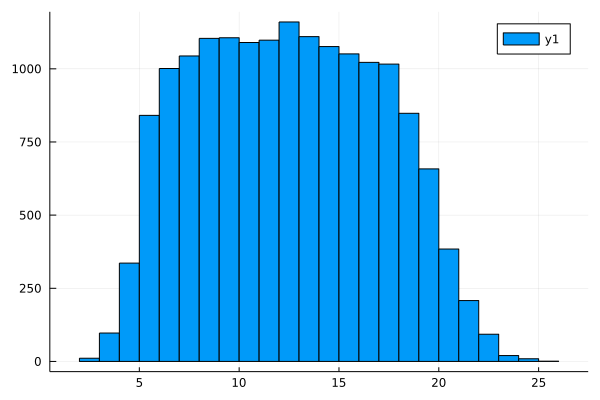

In [12]:
ind = findall(x->x>0,PSR)
histogram(PSR[ind])